# Logistic Regression

In [1]:
import sys
from pathlib import Path

# Start at the current directory
root = Path().resolve()

while not (root / "src" / "rice_ml").exists() and root != root.parent:
    root = root.parent

sys.path.append(str(root / "src"))

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from rice_ml.supervised_learning.logistic_regression import LogisticRegression
from rice_ml.supervised_learning.preprocess import train_test_split, standardize_fit, standardize_transform, make_xy_dataframe

sns.set_theme()

### Loading and preparing the dataset

In [7]:
csv_path = root / "data" / "pima-indians-diabetes.csv"  # adjust name if needed

cols = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age",
    "Outcome",  # 0 or 1
]

diabetes = pd.read_csv(csv_path, header=None, names=cols)

print("Shape:", diabetes.shape)
diabetes.head()

Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Here, we create our X by combining all 8 numeric predictors into one feature vector. "Outcome", indicating whether the woman was diagnosed with diabetes or not, becomes Y, or the target variable of our Logistic Regression.

In [12]:
# Build full feature matrix X and label vector y
feature_cols = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age",
]
target_col = "Outcome"

X = diabetes[feature_cols].to_numpy(dtype=float)
y = diabetes[target_col].to_numpy(dtype=int)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape: ", y_test.shape)


X_train shape: (614, 8)
X_test shape:  (154, 8)
y_train shape: (614,)
y_test shape:  (154,)


As in other notebooks, we can first split our dataset into testing and training data.

We end up with 614 observations in our training data and 154 observations in our testing data.

In [16]:
# Fit on training features only
mean_train, std_train = standardize_fit(X_train)

# Transform both train and test
X_train_std = standardize_transform(X_train, mean_train, std_train)
X_test_std  = standardize_transform(X_test,  mean_train, std_train)

Also like in other notebooks, we can also standardize the features to prevent features with larger numeric scales from dominating the regression.

In [19]:

df_train = pd.DataFrame({
    "x": list(X_train_std),
    "y": y_train
})

df_test = pd.DataFrame({
    "x": list(X_test_std),
    "y": y_test
})

df_train.head()

,x,y
0,"[-0.5133859063701559, -0.3802283869875909, -0....",0
1,"[-1.123093733277846, -0.6559688156612692, -3.4...",0
2,"[1.0108836608990692, -0.043212307497539744, -3...",0
3,"[2.2302993147144496, 0.5389063752580032, 0.264...",1
4,"[-0.818239819824001, -0.1044879583139127, 0.97...",1


Here, we create our X by combining all 8 numeric predictors into one feature vector. "Outcome", indicating whether the woman was diagnosed with diabetes or not, becomes Y, or the target variable of our Logistic Regression.

### Training and Testing

In [35]:

df_train = make_xy_dataframe(X_train_std, y_train, vector_col="x", label_col="y")
df_test  = make_xy_dataframe(X_test_std,  y_test,  vector_col="x", label_col="y")

log_reg = LogisticRegression(
    learning_rate=0.1,
    n_epochs=1000,
    vector_col="x",
    label_col="y",
    random_state=123,
)

log_reg.fit(df_train)

train_acc = log_reg.score(df_train)
test_acc = log_reg.score(df_test)

print(f"Training accuracy: {train_acc:.3f}")
print(f"Test accuracy:     {test_acc:.3f}")

Training accuracy: 0.792
Test accuracy:     0.708


Now that our data is properly setup, we can begin training and testing our Logistic Regression model. Let us start with a model with a learning rate of 0.1 and 1000 training epochs.

Behind the scenes, the model uses gradient descent to optimize the model's weights and biases. We can then see the accuracy of our fitted model on both our training and testing set.

In [36]:
# Search over different learning rates and track train/test accuracy

learning_rates = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0]
results = []

for lr in learning_rates:
    model = LogisticRegression(
        learning_rate=lr,
        n_epochs=1000,
        vector_col="x",
        label_col="y",
        random_state=12,
    )
    model.fit(df_train)

    train_acc = model.score(df_train)
    test_acc = model.score(df_test)

    results.append((lr, train_acc, test_acc))
    print(f"lr = {lr:<6}  train_acc = {train_acc:.3f}  test_acc = {test_acc:.3f}")

# Find the best learning rate by test accuracy
best_lr, best_train_acc, best_test_acc = max(results, key=lambda t: t[2])


lr = 0.001   train_acc = 0.769  test_acc = 0.695
lr = 0.01    train_acc = 0.783  test_acc = 0.701
lr = 0.05    train_acc = 0.792  test_acc = 0.708
lr = 0.1     train_acc = 0.792  test_acc = 0.708
lr = 0.5     train_acc = 0.792  test_acc = 0.708
lr = 1.0     train_acc = 0.792  test_acc = 0.708


From our test of various learning rates, we can see that our initial choice of 0.1 is strong and optimal for test set accuracy. We will thus stick with a learning rate of 0.1 and a number of training epochs of 1000 for our final Logistic Regression model.

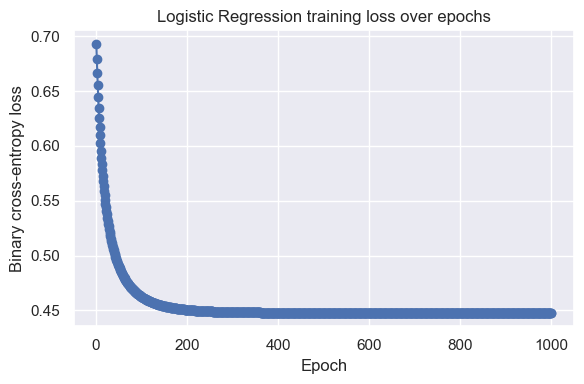

In [37]:
# Plot training binary cross-entropy loss over epochs

losses = log_reg.losses_
epochs = np.arange(1, len(losses) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy loss")
plt.title("Logistic Regression training loss over epochs")
plt.grid(True)
plt.tight_layout()
plt.show()


In the above plot, we can see our model's binary cross-entropy loss over each training epoch as the model runs.

With a small number of training epochs, the model's training loss is high as the weights are still effectively random and predictive ability is low. As we update the parameters with each training epoch, the model is able to learn from the features and increasingly assign higher probabilities to the correct diabetes outcomes. Each additional training epoch makes smaller incremental benefits and the cross-entropy los flattens out at around 0.45.

In [38]:
# Learned coefficients for each feature

print("Bias (b):", log_reg.b_)
print("\nCoefficients (w):")
for name, coef in zip(feature_cols, log_reg.w_):
    print(f"{name:25s}: {coef: .4f}")


Bias (b): -1.0671177987898677

Coefficients (w):
Pregnancies              :  0.4385
Glucose                  :  1.1232
BloodPressure            : -0.2785
SkinThickness            :  0.0249
Insulin                  : -0.1769
BMI                      :  0.7654
DiabetesPedigreeFunction :  0.2970
Age                      :  0.1994


Our model's coefficients indicate how much our standardized features contribtue to the log-odds of an individual patient having diabetes.

Positive coefficients suggest that higher values of that feature increae the likelihood of diabetes while negative coefficients suggest that higher values of that feature decrease the likelihood of diabetes.

In our model, glucose, BMI, and the diabeted pedigree function (quantification of genetic predisposition to diabetes) appear to be the most influential features of this specific fitted model.

### Prediction

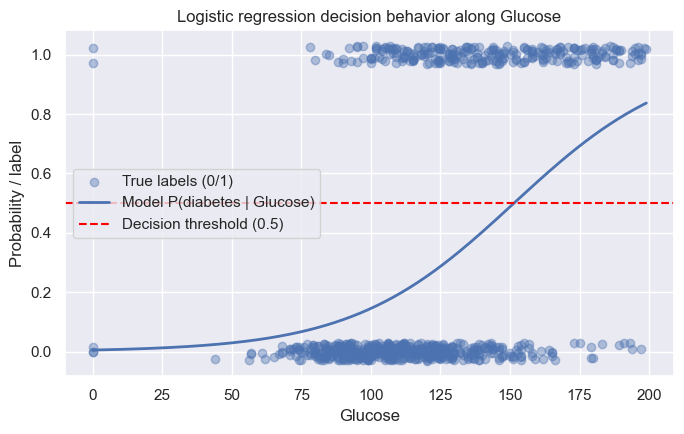

In [39]:
# Visualizing how the logistic regression model makes decisions along "Glucose"

# 1. Predicted probabilities for all patients (using standardized features)
X_std_all = standardize_transform(X, mean_train, std_train)
df_all = make_xy_dataframe(X_std_all, y, vector_col="x", label_col="y")
probs_all = log_reg.predict_proba(df_all)

plot_df = diabetes.copy()
plot_df["proba"] = probs_all

# 2. Build a smooth probability curve as a function of Glucose
feature_idx = feature_cols.index("Glucose")

glucose_grid = np.linspace(
    diabetes["Glucose"].min(),
    diabetes["Glucose"].max(),
    200
)

# Start from an "average" patient in raw feature space
X_grid = np.tile(mean_train, (len(glucose_grid), 1))   # all features at their train means
X_grid[:, feature_idx] = glucose_grid                  # vary only Glucose

# Standardize using the same mean/std as training
X_grid_std = standardize_transform(X_grid, mean_train, std_train)

dummy_y = np.zeros(len(glucose_grid), dtype=int)
df_grid = make_xy_dataframe(X_grid_std, dummy_y, vector_col="x", label_col="y")
probs_grid = log_reg.predict_proba(df_grid)

# 3. Plot: data points (Glucose vs true Outcome) + model probability curve
plt.figure(figsize=(7, 4.5))

# Jitter the true 0/1 labels slightly so points don't sit exactly on top of each other
jitter = np.random.uniform(-0.03, 0.03, size=len(plot_df))
plt.scatter(
    plot_df["Glucose"],
    plot_df["Outcome"] + jitter,
    alpha=0.4,
    label="True labels (0/1)",
)

# Model's smooth probability as a function of Glucose
plt.plot(
    glucose_grid,
    probs_grid,
    linewidth=2,
    label="Model P(diabetes | Glucose)",
)

# Decision threshold at 0.5
plt.axhline(0.5, linestyle="--", color="red", label="Decision threshold (0.5)")

plt.xlabel("Glucose")
plt.ylabel("Probability / label")
plt.title("Logistic regression decision behavior along Glucose")
plt.legend()
plt.tight_layout()
plt.show()


Let's consider how the model interprets an observation's glucose level into a probability of Diabetes.

On the plot, we have each observation's glucose level as well as whether or not they have diabetes (1 and 0 respectively). Assuming that all other features are held constant, as the glucose level increases, our model finds it increasingly probable that the patient has diabetes.

Once the probability determined by the glucose level crosses the 0.5 threshold, the logistic model switches from predicting that the patient does not have diabetes, to predicting that the patient does have diabetes.

Although it is true that the majority of patients with diabetes had high glucose values, there is still a notable number of patients without diabetes with high glucose values as well, and this sort of overlap explains why our model only has a test accuracy of ~70%.

In [40]:
# Evaluate logistic regression with a confusion matrix on the test set

# Get predicted labels on the test set (using the default 0.5 threshold)
y_test_pred = log_reg.predict(df_test)

conf_mat = pd.crosstab(
    pd.Series(y_test, name="True label"),
    pd.Series(y_test_pred, name="Predicted label"),
)

print("Confusion matrix (test set):")
display(conf_mat)


Confusion matrix (test set):


Predicted label,0,1
True label,,
0,75,9
1,36,34


This confusion matrix indicates the aggregate performance of our logistic regression on the test set.

The model correctly identifies 75 patients as not having diabetes, but incorrectly assigns 9 false positives. The model correctly identifies 34 patients as having diabetes, but incorrectly assigns 36 false negatives.

Interestingly, the model performs much better at identifying patients without diabetes than it is for predicting diabetes, which is an important limitation of the model if it were to be used in a real-world medical setting.